In [ ]:
# !git clone 'https://github.com/Lorenz92/SKADC1.git'
# % cd SKADC1
# !echo $PWD

In [ ]:
import pandas as pd
import numpy as np

import src.dataset as dataset
import src.config as config 
from src.utils import *

path = config.TRAIN_PATCHES_FOLDER
%load_ext autoreload
%autoreload 2

np.random.seed(config.RANDOM_SEED)

In [ ]:
if 'google.colab' in str(get_ipython()):
  use_colab = True
  print('Running on CoLab')
else:
  use_colab = False
  print('Not running on CoLab')

In [ ]:
if use_colab:
    # Read file from Colab Notebook
    from google.colab import drive
    drive.mount('/content/drive')
    config.MODEL_WEIGHTS = "/content/drive/My Drive/Colab Notebooks/SKADC1"
    config.IMAGE_PATH = "/content/drive/My Drive/Colab Notebooks/SKADC1/asset/560Mhz_1000h.fits"

In [ ]:
# Choose the feature extraction model
backbone='baseline_16'
# backbone='vgg16'

if backbone=='baseline_16':
    config.patch_dim = 20
    config.resizePatch = True
    config.rpn_stride = 4
    config.num_rois = 128
    # config.anchor_box_scales = [16,32,64] # anchors in the original image size
    config.anchor_box_scales = [6, 8, 12, 16, 24, 32]
    config.resizeFinalDim = 100
    input_shape_1 = config.resizeFinalDim
else:
    config.patch_dim = 100
    config.resizePatch = True
    config.rpn_stride = 16
    config.num_rois = 4
    config.resizeFinalDim = 600
    input_shape_1=config.resizeFinalDim
    config.anchor_box_scales = [32, 64, 128]


config.anchor_num = len(config.anchor_box_ratios)*len(config.anchor_box_scales)
input_shape_2=(None, 4)

print(config.resizePatch)
print(config.rpn_stride)

checkpoint = get_model_last_checkpoint(backbone)
print(f'Model last checkpoint: {checkpoint}')

In [ ]:
# Dataset parsing and loading
# use "subset" in config file to load a small portion of data for development/debugging purposes
ska_dataset = dataset.SKADataset(k=3, print_info=False, use_pb=False)

In [ ]:
ska_dataset.cleaned_train_df[['width', 'height', 'area_orig', 'area_cropped']].describe()

In [ ]:
ska_dataset.cleaned_train_df[['width', 'height', 'area_orig']].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.98,.99,1.])

In [ ]:
# print(int(np.floor(min(ska_dataset.cleaned_train_df['x1']))))
# print(int(np.floor(min(ska_dataset.cleaned_train_df['y1']))))

In [ ]:
# ska_dataset.cleaned_train_df[np.isin(ska_dataset.cleaned_train_df['ID'],[20167150, 27514971])].iloc[:,10:].head()


In [ ]:
# # 16376
# # 16729

# # img_patch = ska_dataset.image_data[16729:16810,16376:16490]*10000000
# img_patch = ska_dataset.image_data[16759:16779,16436:16456]*1000000
# plt.imshow(img_patch, cmap='viridis', vmax=255, vmin=0)


In [ ]:
# # 16436
# # 16779

# img_patch = ska_dataset.original_cropped_image[0:81,0:114]*1000000
# # img_patch = ska_dataset.image_data*10000000
# plt.imshow(img_patch, cmap='viridis', vmax=255, vmin=0)


In [ ]:
objects_to_ignore=[20167150, 27514971]


In [ ]:
# objects_to_ignore_df = ska_dataset.cleaned_train_df.loc[ska_dataset.cleaned_train_df['ID'].isin(objects_to_ignore)]
# display(objects_to_ignore_df)

In [ ]:
show_plot = False
ska_dataset.generate_patches(limit=100, plot_patches=show_plot, objects_to_ignore=objects_to_ignore, source_dir='./data/training/patches', rgb_norm=True)
# ska_dataset.generate_patches(limit=1600, plot_patches=show_plot, objects_to_ignore=objects_to_ignore, source_dir='./data/training/patches', rgb_norm=True)

In [65]:
ska_dataset.proc_train_df[ska_dataset.proc_train_df['class_label'] != '2_3'].head(200)

,index,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,...,x2s,y2s,class_label,patch_id,patch_name,patch_xo,patch_yo,patch_dim,bbox_w,bbox_h
0,0,13302538,-0.005224,-29.939449,-0.005224,-29.939449,0.000017,0.861438,0.076,0.076,...,16.453581,17.232278,2_2,2_16396_16729_20,560Mhz_1000h_16396_16729,16396,16729,20,4.967293,4.967293
2,0,13302538,-0.005224,-29.939449,-0.005224,-29.939449,0.000017,0.861438,0.076,0.076,...,6.453581,17.232278,2_2,3_16406_16729_20,560Mhz_1000h_16406_16729,16406,16729,20,4.967293,4.967293
8,0,13302538,-0.005224,-29.939449,-0.005224,-29.939449,0.000017,0.861438,0.076,0.076,...,16.453581,7.232278,2_2,161_16396_16739_20,560Mhz_1000h_16396_16739,16396,16739,20,4.967293,4.967293
10,0,13302538,-0.005224,-29.939449,-0.005224,-29.939449,0.000017,0.861438,0.076,0.076,...,6.453581,7.232278,2_2,162_16406_16739_20,560Mhz_1000h_16406_16739,16406,16739,20,4.967293,4.967293


In [67]:
a = ska_dataset.proc_train_df.groupby('patch_id').class_label.nunique().to_frame().reset_index()
a.head(20)

,patch_id,class_label
0,1281_16466_16809_20,1
1,1432_16386_16819_20,1
2,1433_16396_16819_20,1
3,1440_16466_16819_20,1
4,161_16396_16739_20,2
5,162_16406_16739_20,2
6,165_16436_16739_20,1
7,166_16446_16739_20,1
8,167_16456_16739_20,1
9,2_16396_16729_20,2


In [80]:
b = np.array(a['patch_id'][a['class_label'] ==1]).tolist()
b

['1281_16466_16809_20',
 '1432_16386_16819_20',
 '1433_16396_16819_20',
 '1440_16466_16819_20',
 '165_16436_16739_20',
 '166_16446_16739_20',
 '167_16456_16739_20',
 '638_16396_16769_20',
 '6_16436_16729_20',
 '797_16396_16779_20',
 '7_16446_16729_20',
 '8_16456_16729_20']

In [82]:
ska_dataset.proc_train_df[(ska_dataset.proc_train_df['class_label'] !='2_3') & (ska_dataset.proc_train_df['patch_id'].isin(b))] 

,index,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,...,x2s,y2s,class_label,patch_id,patch_name,patch_xo,patch_yo,patch_dim,bbox_w,bbox_h


1 1 180


,minor_semia_px,pa_in_rad,width,height,area_orig,area_cropped,x1s,y1s,x2s,y2s,class_label,patch_id,patch_name,patch_xo,patch_yo,patch_dim,bbox_w,bbox_h
0,2.600407,-0.314491,7.52438,5.493366,41.334178,41.334178,11.593521,16.294071,19,19,2_3,6_16436_16729_20,560Mhz_1000h_16436_16729,16436,16729,20,7.406479,2.705929


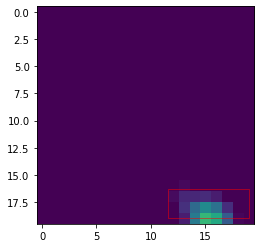

,minor_semia_px,pa_in_rad,width,height,area_orig,area_cropped,x1s,y1s,x2s,y2s,class_label,patch_id,patch_name,patch_xo,patch_yo,patch_dim,bbox_w,bbox_h
0,2.600407,-0.314491,7.52438,5.493366,41.334178,41.334178,58.0,82.0,95,95,2_3,6_16436_16729_20,560Mhz_1000h_16436_16729,16436,16729,20,7.406479,2.705929


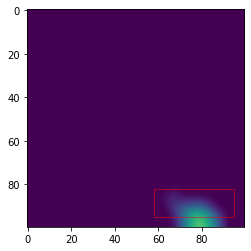

In [87]:
from src.preprocessing import augment

def augment_patch(image_path, image_data_path):
    hflip = np.random.randint(0, 2)
    vflip = np.random.randint(0, 2)
    angle = np.random.choice([0,90,180,270],1)[0]

    img, img_data_aug  = augment(image_path, image_data_path, augment=True, hflip=hflip, vflip=vflip, angle=angle)

    return img, img_data_aug, hflip, vflip, angle

patches_list = ['6_16436_16729_20']

def rebalance_given_class(patches_list):
    # Temporarely store resizePatch param in order to avoid resizing during augmentation
    original_resizePatch_param = config.resizePatch
    config.resizePatch = False

    for patch_id in patches_list:
        image_path = os.path.join(config.TRAIN_PATCHES_FOLDER, patch_id, f"{patch_id}.npy")
        image_data_path = os.path.join(config.TRAIN_PATCHES_FOLDER, patch_id, f"{patch_id}.pkl")

        img, img_data_aug, hflip, vflip, angle = augment_patch(image_path, image_data_path)

        print(hflip, vflip, angle)
        new_patch_name = f'{patch_id}_{hflip}_{vflip}_{angle}'

        if not os.path.exists(os.path.join(config.TRAIN_PATCHES_FOLDER, f"{new_patch_name}")):
            os.makedirs(os.path.join(config.TRAIN_PATCHES_FOLDER, f"{new_patch_name}/"))

        np.save(os.path.join(config.TRAIN_PATCHES_FOLDER, f"{new_patch_name}/{new_patch_name}.npy"), img)
        img_data_aug.to_pickle(os.path.join(config.TRAIN_PATCHES_FOLDER, f"{new_patch_name}/{new_patch_name}.pkl"))

    config.resizePatch = original_resizePatch_param

    return

print_img(config.TRAIN_PATCHES_FOLDER, patch_id, show_data=True)

print_img(config.TRAIN_PATCHES_FOLDER, new_patch_name, show_data=True)


In [ ]:
# ska_dataset.analyze_class_distribution()

In [ ]:
# ska_dataset.split_train_val_stratified(random_state=42, val_portion=0.2)

# print(len(ska_dataset.train_patch_list))
# print(len(ska_dataset.val_patch_list))


Train list consists of 12 patches
Val list consists of 4 patches


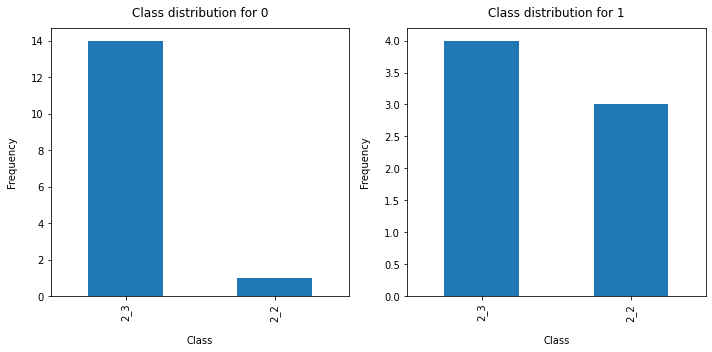

In [40]:
ska_dataset.split_train_val(random_state=42, val_portion=0.2)

## datagen + calc_rpn -> rpn_net -> rpn_to_roi -> calc_iou -> cls_net

# Training

In [ ]:
# print_img(config.TRAIN_PATCHES_FOLDER, '3_16406_16729_20', show_data=True)


In [ ]:
# # Debugging

# train_patch_list = ska_dataset.train_patch_list
# patches_folder_path=config.TRAIN_PATCHES_FOLDER

# train_datagen = prep.get_anchor_gt(patches_folder_path, ['20_16396_16729_20'], backbone, pixel_mean=None)
# image, [y_rpn_cls_true, y_rpn_reg_true], img_data_aug, _, _, patch_id = next(train_datagen)



### Get FRCNN model

In [ ]:
# # Choose the feature extraction model
# backbone='baseline_16'
# # backbone='vgg16'

# if backbone=='baseline_16':
#     config.resizePatch = True
#     config.rpn_stride = 4
#     config.num_rois = 128
#     # config.anchor_box_scales = [16,32,64] # anchors in the original image size
#     config.anchor_box_scales = [6, 8, 12, 16, 24, 32]
#     config.resizeFinalDim = 100
#     input_shape_1 = config.resizeFinalDim
# else:
#     config.resizePatch = True
#     config.rpn_stride = 16
#     config.num_rois = 4
#     config.resizeFinalDim = 600
#     input_shape_1=config.resizeFinalDim
#     config.anchor_box_scales = [32, 64, 128]


# config.anchor_num = len(config.anchor_box_ratios)*len(config.anchor_box_scales)
# input_shape_2=(None, 4)

# print(config.resizePatch)
# print(config.rpn_stride)

# checkpoint = get_model_last_checkpoint(backbone)
# print(f'Model last checkpoint: {checkpoint}')

In [ ]:
rpn_model, detector_model, total_model = models.get_train_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, anchor_num=config.anchor_num, pooling_regions=config.pooling_regions, num_rois=config.num_rois, num_classes=len(ska_dataset.class_list)+1, backbone=backbone, use_expander=False)

rpn_model.summary()
detector_model.summary()
total_model.summary()

### Load weights

In [ ]:
models.load_weigths(rpn_model, detector_model, backbone, resume_train=False, checkpoint=checkpoint)
models.compile_models(rpn_model, detector_model, total_model, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=ska_dataset.class_list)

In [ ]:
# Specifically checking backbone weights

# total_model.weights[24:25][0][0][0][0]

In [ ]:
# Check that all of the pretrained weights have been loaded.
import numpy as np
for i, j in zip(total_model.weights, rpn_model.weights): 
    # print(i,j)
    assert np.allclose(i,j), 'Weights don\'t match!'

### Train

- errore "Exception: 'a' cannot be empty unless no samples are taken" quando nel sampling ci sono meno di 4 roi
- errore "None type object is not iterable" dovuto al max(IoUs) quando calc_iou torna None, None, None, None
- patch di debug 1550_16376_16779_100
- capire il parametro classifier_regr_std in che modo influenza il training

- provare normalizzazione valori immagini di input
- provare a far passare più roi anzichè 4

In [ ]:
# zzz = np.load(f'{config.TRAIN_PATCHES_FOLDER}/3100_16376_16829_100/3100_16376_16829_100.npy')

# print_img(config.TRAIN_PATCHES_FOLDER, '3100_16376_16829_100')

20_16396_16729_20

In [ ]:
len(ska_dataset.train_patch_list)

In [ ]:
from src.train import *

val_patch_list = None
# train_frcnn(rpn_model, detector_model, total_model, ['2_16396_16729_20'], val_patch_list, ska_dataset.class_list, num_epochs=100, patches_folder_path=config.TRAIN_PATCHES_FOLDER, backbone=backbone, resume_train=False)
train_frcnn(rpn_model, detector_model, total_model, ska_dataset.train_patch_list, val_patch_list, ska_dataset.class_list, num_epochs=1000, patches_folder_path=config.TRAIN_PATCHES_FOLDER, backbone=backbone, resume_train=True)

# Validation

In [30]:
rpn_model_eval, detector_model_eval, total_model_eval = models.get_eval_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, input_shape_fmap=None, anchor_num=config.anchor_num, pooling_regions=config.pooling_regions, num_rois=config.num_rois, num_classes=len(ska_dataset.class_list)+1, backbone=backbone, use_expander=False)

rpn_model_eval.summary()
detector_model_eval.summary()
total_model_eval.summary()

Model: "RegionProposal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)    

In [31]:
# Models used for mAP eval
cp = '0_frcnn_baseline_16.h5'
models.load_weigths(rpn_model_eval, detector_model_eval, backbone, checkpoint=cp)
models.compile_models(rpn_model_eval, detector_model_eval, total_model_eval, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=ska_dataset.class_list)

In [32]:
# patch_id = ['3_16406_16729_20']
patch_id = ska_dataset.train_patch_list
# print(patch_id)
# gt = pd.read_pickle(f'{config.TRAIN_PATCHES_FOLDER}/{patch_id[0]}/{patch_id[0]}.pkl')
# display(gt['class_label'])

preds, mAP, prec, recall = evaluate_model(rpn_model_eval, detector_model_eval, backbone, patch_id, ska_dataset.class_list, metric_threshold=.5)

(100, 100)
{0: '2_2', 1: '2_3', 2: 'bg'}
Predict
rpn_to_roi
[[[1.8197085e-07 7.4953228e-01 2.5046757e-01]
  [1.8197085e-07 7.4953228e-01 2.5046757e-01]
  [1.8197085e-07 7.4953228e-01 2.5046757e-01]
  [1.8197085e-07 7.4953228e-01 2.5046757e-01]
  [1.8197085e-07 7.4953228e-01 2.5046757e-01]
  [1.8197085e-07 7.4953228e-01 2.5046757e-01]
  [1.8197085e-07 7.4953228e-01 2.5046757e-01]
  [1.8197085e-07 7.4953228e-01 2.5046757e-01]
  [1.8197085e-07 7.4953228e-01 2.5046757e-01]
  [1.8197085e-07 7.4953228e-01 2.5046757e-01]
  [1.8197085e-07 7.4953228e-01 2.5046757e-01]
  [1.8197085e-07 7.4953228e-01 2.5046757e-01]
  [1.8197085e-07 7.4953228e-01 2.5046757e-01]
  [1.8197085e-07 7.4953228e-01 2.5046757e-01]
  [1.8197085e-07 7.4953228e-01 2.5046757e-01]
  [1.8197085e-07 7.4953228e-01 2.5046757e-01]
  [1.8197085e-07 7.4953228e-01 2.5046757e-01]
  [1.8197085e-07 7.4953228e-01 2.5046757e-01]
  [1.8197085e-07 7.4953228e-01 2.5046757e-01]
  [1.8197085e-07 7.4953228e-01 2.5046757e-01]
  [1.8197085e-07 7.4

In [ ]:
preds

In [ ]:
print(config.patch_dim , float(config.resizeFinalDim))

In [ ]:
print_img(config.TRAIN_PATCHES_FOLDER, '161_16396_16739_20')

In [33]:
anch = pd.read_pickle(f'{config.EVAL_RESULTS}/6_16436_16729_20/6_16436_16729_20.pkl')
display(anch)

,x1s,y1s,x2s,y2s,class,prob
0,0,0,0,0,2_3,0.749532
1,6,18,8,19,2_3,0.749532
2,0,15,0,16,2_3,0.749532
3,0,14,0,15,2_3,0.749532
4,17,6,19,7,2_3,0.749532
5,17,5,19,6,2_3,0.749532
6,0,5,0,6,2_3,0.749532
7,17,4,19,5,2_3,0.749532
8,0,4,0,5,2_3,0.749532
9,17,4,19,4,2_3,0.749532


In [ ]:
anch['width'] = anch['x2s'] - anch['x1s']
anch['heght'] = anch['y2s'] - anch['y1s']

In [ ]:
anch.describe() 

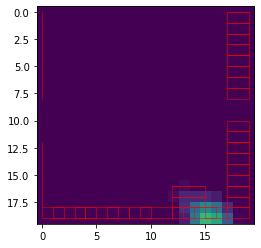

In [34]:
print_img(config.TRAIN_PATCHES_FOLDER, '6_16436_16729_20', config.EVAL_RESULTS)

TODO - 20210508:
- [X] troncamento rumore a 1e-6 tramite half gaussian

TODO - 20210605:
- [X] modificare RPNNet in modo che dia in output anche la backbone - Lorenzo
- [X] scrivere bene training loop: salvare le loss in un df su disco + salvare pesi modello ad ogni giro (Lorenzo - finire di debuggare)

TODO - 20210620:
- [x] implementare mAP in una funzione che prende come parametro un modello o i suoi pesi
- [x] implementare resNet50
- [x] implementare predicted rois - Lorenzo
- [X] implementare plot loss training - Lorenzo
- [X] finire classe datasetv2 - Alice
- [X] check se su colab le performance sono migliori - Lorenzo

TODO - 20210627
- [X] split dataset su combinazioni classi - Alice
- [x] provare campionamento random patch ed osservare le due distribuzioni - Alice

TODO - 20210703
- [x] sistemare salvataggio loss training loop - Lorenzo
- [x] Riscalare immagini tra 0-255 - Alice
- [x] capire se passare tre immagini diverse come input
- [x] usare media vgg16 per zero-centering - Alice

TODO - 20210705
- [x] sistemare nomi funzioni dataset per trasformazione rgb

TODO - 20210711
- [x] rifattorizzare classe dataset spostando nel costruttore i metodi che calcolano i suoi attributi - Lorenzo
- [x] chek valori pixel in input per resnet
- [x] fare funzione per plottare le predictions
- [ ] trainare tutto su colab

TODO - 20210714
- [x] ragionare su come scalare le immagini fra 0 e 1, attualmente hanno tanti valori schiacciati a 0 e il massimo su tutto il train a a 0.4

TODO - 20210717
- [ ] Ablation study: provare a rimuovere stage4 nella resnet - se c'è tempo
- [x] Provare con nostra pixel_mean e con vgg16 pixel_mean -> per il momento abbiamo scartato la prima opzione
- [ ] Fare qualche analisi di distribuzione delle classi/dim box del dataset - Alice
- [x] Aggiungere normalizzazione dopo zero centering per resNet50, sulla base del range globale dell'immagine di training
- [ ] Provare pulizia dataset originale sulla base del rumore/flusso - Alice
- [ ] Cambiare nomi di tutto - alla fine
- [x] implementare zero-centering su volare medio RGB delle nostre patch
- [x] Funzione che trova l'ultimo checkpoint in colab prima del load_weights - Lorenzo

TODO - 20210801
- [x] Debuggare training baseline 8 e 16 - L
- [ ] Finire prove pulizia dataseet noise variando k - A

1.  Summary
    - riassunto progetto
2.  Background
    - SoTA + teoria di base
3.  System Description
    - descrizione dei nostri modelli e dei loro componenti (moduli)
4.  Experimental setup and results
    - dataset pre processing
    - training environment
    - metrics
    - results
5.  Results and error analysis
6.  Discussion

# Plotting

In [35]:
loss_history = np.load(f"./model/{backbone}/loss_history.npy")
print(loss_history.shape)

(2100, 5)


In [ ]:
loss_history

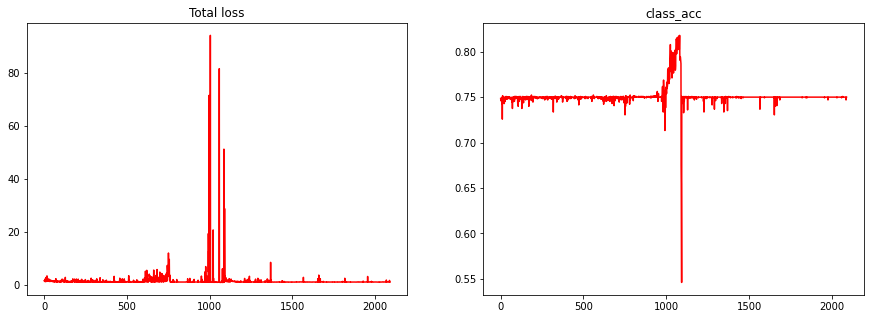

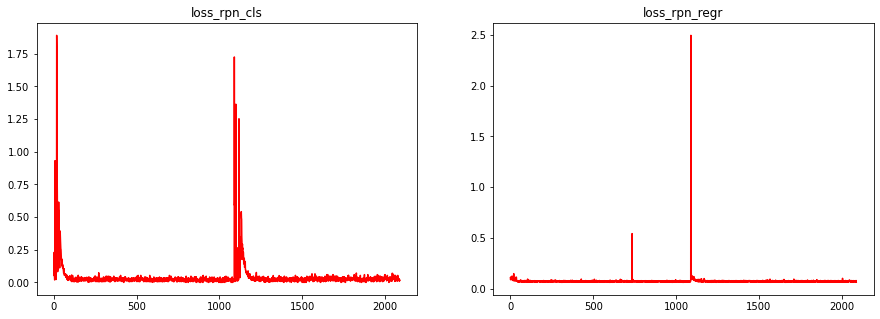

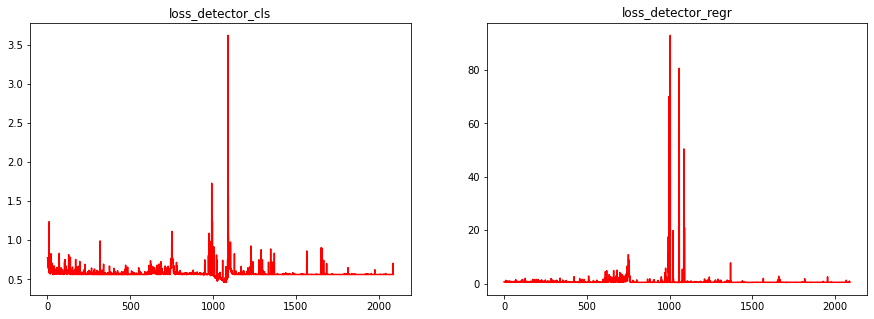

In [36]:
plot_loss(loss_history[10:])